In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from intrinsic_factors import intrinsic_factors_xywh
from fmow_utils import get_fmow_boxes,extrinsic_factors_fmow, validate_dict

from prototype.info_tools import compute_mutual_information, compute_mutual_information_class, str2int

2024-06-13 08:24:12.354859: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 08:24:12.392822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 08:24:12.392852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 08:24:12.393730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 08:24:12.399824: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# load precomputed table of FMOW labels and metadata
df = pd.read_pickle("../trainval_labels_factors.pkl").reset_index(drop=True)
df["class"] = df["class"].astype('category')
df["split"] = df.split.astype("category")
# df = df[df.country_code=="USA"]
# xywh
boxes = get_fmow_boxes(df)
img_sizes = np.column_stack((df.img_width.to_numpy(), df.img_height.to_numpy()))


In [3]:
# gather intrinsic factors (dataset agnostic)
int_fmow, int_categorical = intrinsic_factors_xywh(boxes, img_sizes)

# gather extrinsic factors (custom to FMOW)
ext_fmow, ext_categorical = extrinsic_factors_fmow(df)

# class labels
cls_fmow = {"class":df["class"].to_numpy()}
cls_categorical = {"class": True}

In [4]:
# combine factors
factors = {**cls_fmow, **int_fmow, **ext_fmow}
is_categorical = {**cls_categorical, **int_categorical, **ext_categorical}

# map non-numeric variables to integers
factors = str2int(factors)

# make sure we have a categorical label for each factor
assert(all([k in is_categorical.keys() for k in factors.keys()]))
# make sure each factor has the same number of entries
validate_dict(factors)


In [5]:
# mi,vars = compute_mutual_information(factors, is_categorical)
mi,vars = compute_mutual_information_class(factors, is_categorical)

ValueError: All dimensions of input must be of equal length

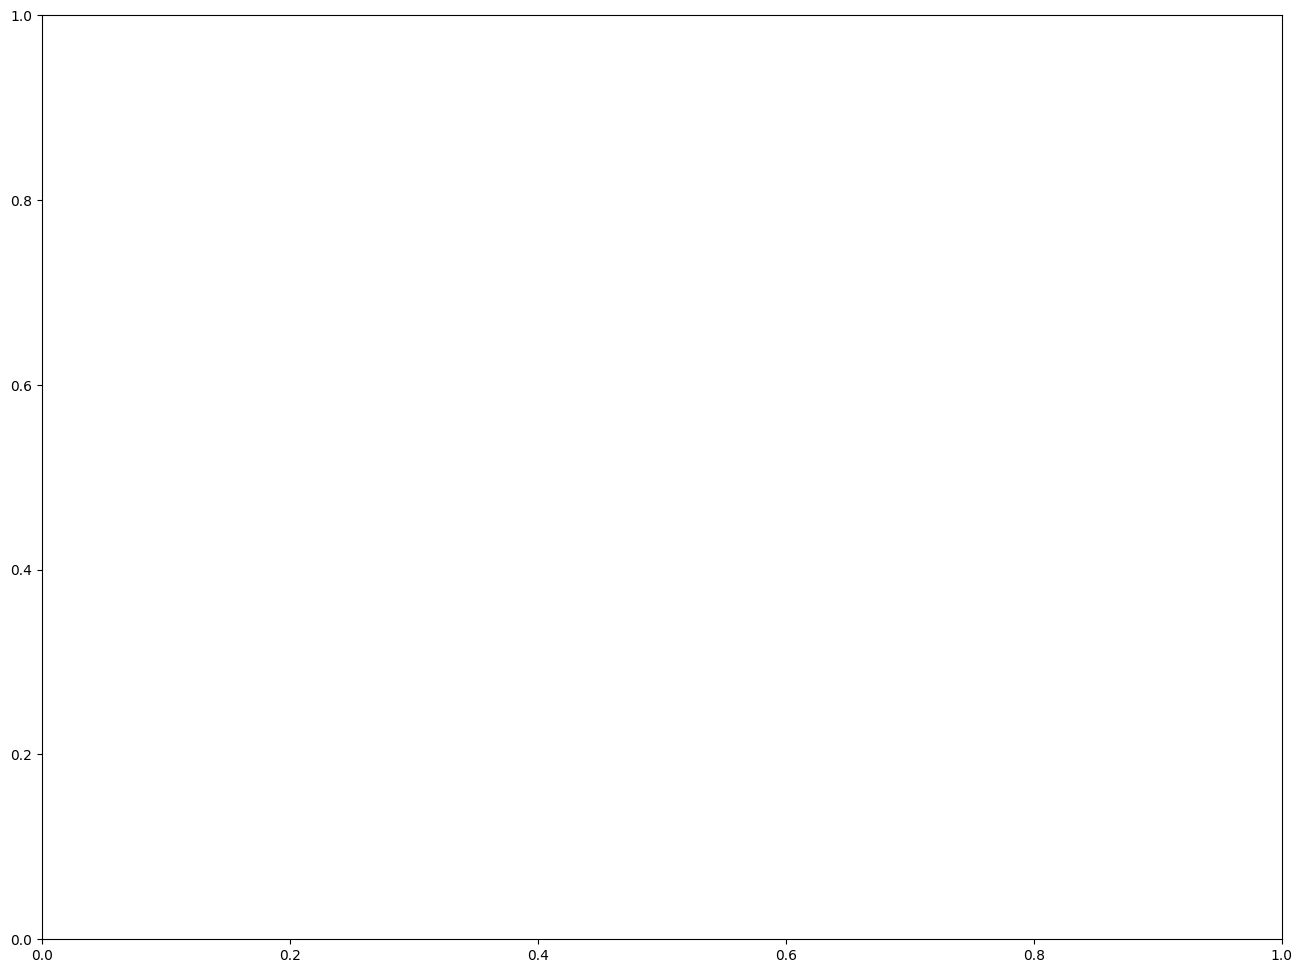

In [6]:
f,ax = plt.subplots(figsize=(16, 12))
mask = np.zeros_like(mi, dtype=np.bool_)
mask[np.tril_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(mi[:,1:], mask=mask[:,1:], cmap=cmap, vmin=0, vmax=1,
        square=True, linewidths=.5, cbar_kws={"shrink": .5, "label":"Mutual Information [nat]"},
        xticklabels=vars[1:], yticklabels=vars,
        annot=True)
# highlight correlation with class
ax.add_patch(Rectangle((0, 0), mi.shape[0], 1, fill=False, edgecolor='k', lw=4))
plt.tight_layout()

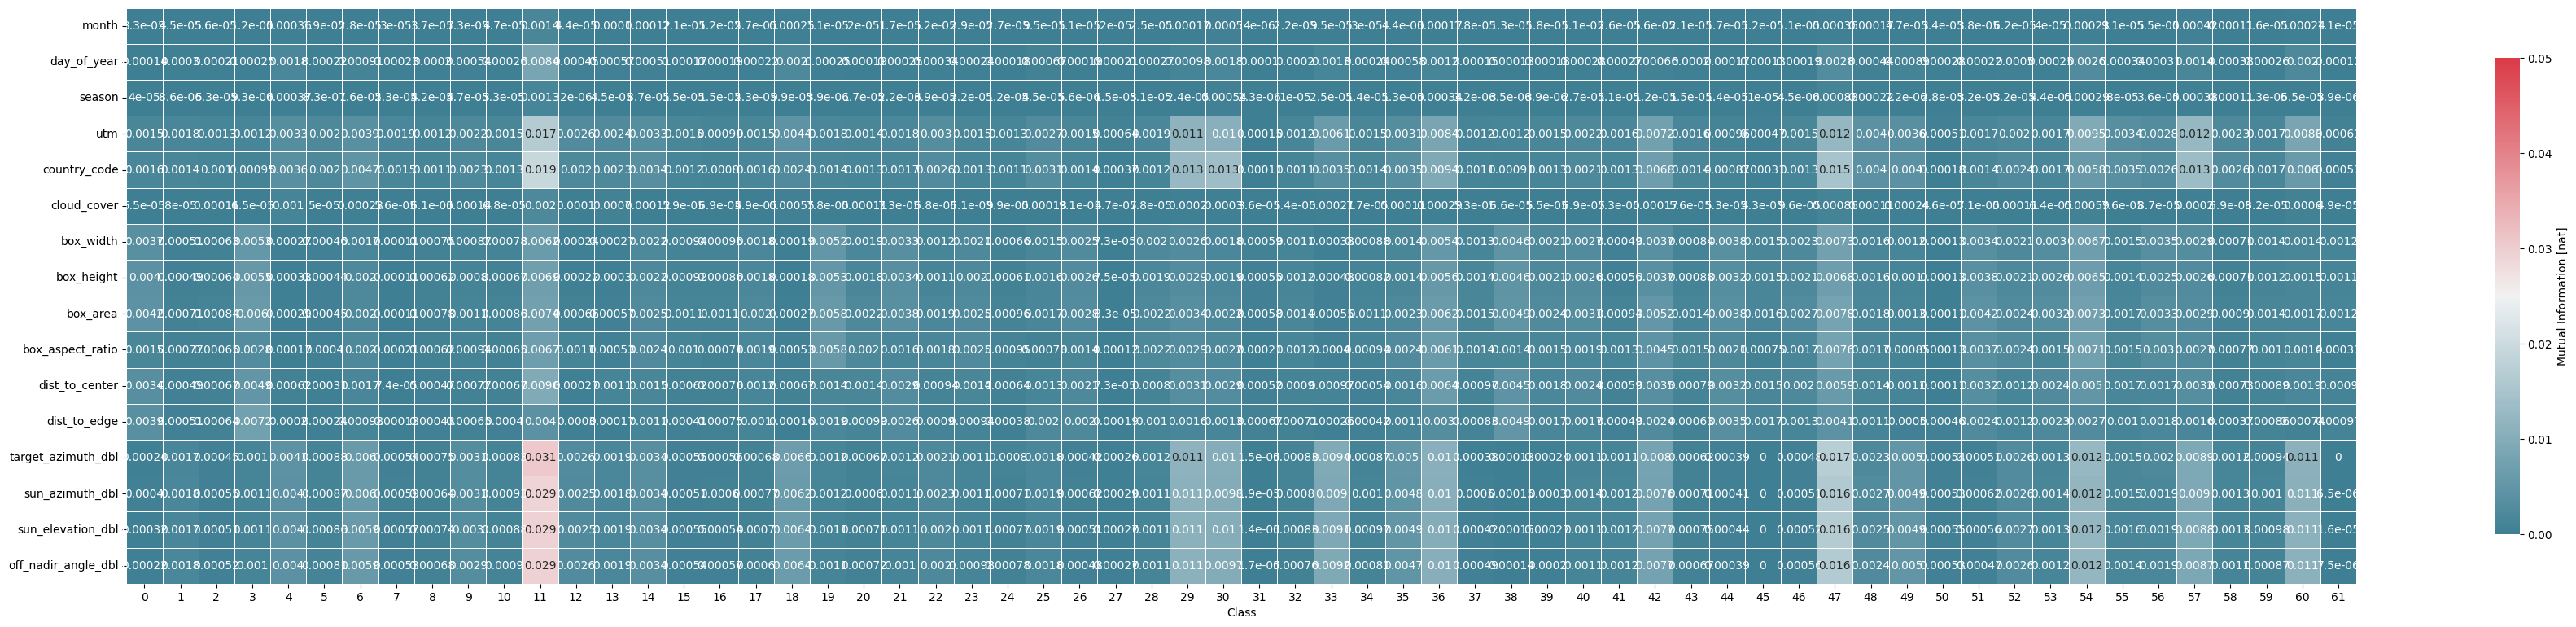

In [14]:

classes = np.unique(factors["class"])

f,ax = plt.subplots(figsize=(36, 12))
# mask = np.zeros_like(mi, dtype=np.bool_)
# mask[np.tril_indices_from(mask)] = True

# # Want diagonal elements as well
# mask[np.diag_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(mi.T, cmap=cmap, vmin=0, vmax=1,
        square=True, linewidths=.5, cbar_kws={"shrink": .5, "label":"Mutual Information [nat]"},
        xticklabels=classes, yticklabels=vars,
        annot=True)
plt.xlabel("Class")
# highlight correlation with class
# ax.add_patch(Rectangle((0, 0), mi.shape[0], 1, fill=False, edgecolor='k', lw=4))
plt.tight_layout()

In [20]:
np.unique(cls_fmow["class"])

array(['airport', 'airport_hangar', 'airport_terminal', 'amusement_park',
       'aquaculture', 'archaeological_site', 'barn', 'border_checkpoint',
       'burial_site', 'car_dealership', 'construction_site', 'crop_field',
       'dam', 'debris_or_rubble', 'educational_institution',
       'electric_substation', 'factory_or_powerplant', 'fire_station',
       'flooded_road', 'fountain', 'gas_station', 'golf_course',
       'ground_transportation_station', 'helipad', 'hospital',
       'impoverished_settlement', 'interchange', 'lake_or_pond',
       'lighthouse', 'military_facility', 'multi-unit_residential',
       'nuclear_powerplant', 'office_building', 'oil_or_gas_facility',
       'park', 'parking_lot_or_garage', 'place_of_worship',
       'police_station', 'port', 'prison', 'race_track', 'railway_bridge',
       'recreational_facility', 'road_bridge', 'runway', 'shipyard',
       'shopping_mall', 'single-unit_residential', 'smokestack',
       'solar_farm', 'space_facility', 'stad